In [95]:
# This script parses html files generated from facebook.com.
# It converts these into pandas dataframes in order to visualize the total number of conversation with all your contacts.
# The data can be requested from facebook via ...
# Written by Marvin Nicolas Pohl, Berkeley 2019

# import modules
import codecs
import re
import pandas as pd
from datetime import datetime
#from dateutil.parser import parse
import numpy as np
#from matplotlib import pyplot
#from matplotlib.pyplot import figure
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
import tkinter as tk # choose a file
from tkinter import filedialog # dialog to choose a file

In [ ]:
# open file choose dialog
#root = tk.Tk()
#root.withdraw()
#file_path = filedialog.askopenfilename()
file_path = 'adrianabe_a8b5a7046f/message.html'

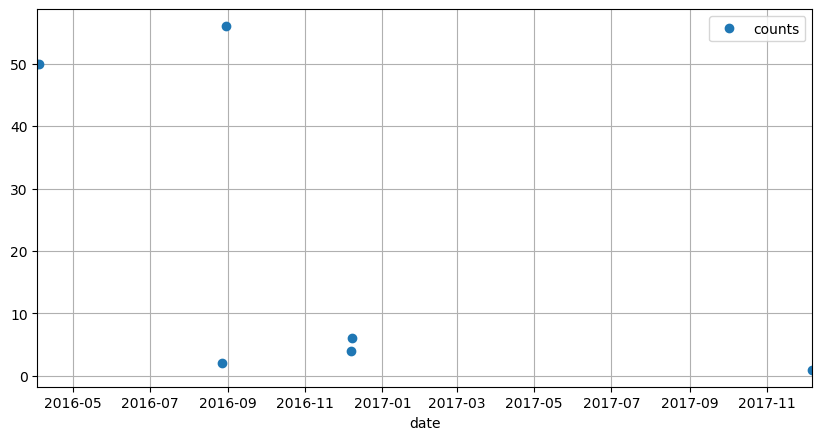

In [155]:
# define functions

# read messages.html file and create a string
def load_file(path):
    html = codecs.open(path, 'r').read()
    
    return html


# parse the string and convert it into a pandas dataframe containing 'date', 'name' and 'text'
# additionally, extract the user name and the name of the dialog partner
# return dataframe, user_name, dialog_partner
def html_string_to_dataframe(html):
    
    # split string to list of strings
    split_string = html.split('</div></div>')
    
    # remove empty elements in 'split_string'
    lst = []
    for elem in split_string:
        if '<div' in elem:
            lst.append(elem)
    
    # reverse list order
    lst.reverse()
    
    # remove irrelevant characters from list elements that contain 'date' information
    # in the original string the 'date' is always printed after a "> string
    short_lst = []
    for elem in lst:
        cut = (re.search('">(.*)', elem).group(1))
        short_lst.append(cut)
    
    # extract the user name
    user_name = re.search('Generated by (.*) on', short_lst[0]).group(1)
    
    # drop first and last 4 elements of 'split_string' since they contain irrelevant information
    short_lst = short_lst[1:-4]
    
    # cut out 'names' and 'message' text out of the string list and cast them into a touple
    lst = []
    for elem in short_lst:
        if 'div class=' in elem:
            cut = (re.search('\">(.*)</div', elem).group(1), re.search('<div><div>(.*)', elem).group(1))
            lst.append(cut)
        else: lst.append(elem)
    
    # arrange 'date', 'name' and 'text' in a list of triplets
    triplet_lst = []
    for i in list(range(0,len(lst),2)):
        merged_elem = (lst[i], lst[i+1][0], lst[i+1][1])
        triplet_lst.append(merged_elem)
        
    # extract the name of the dialog partner
    for elem in np.transpose(triplet_lst)[1]:
        if elem != user_name:
            dialog_partner = elem
            break

    # load 'triplet_lst' as pandas dataframe
    dataframe = pd.DataFrame(triplet_lst)
    
    # lable colums
    dataframe = dataframe.rename(columns={0: 'date', 1: 'name', 2: 'text'})
    
    return dataframe, user_name, dialog_partner


# the 'date' entries in the dataframe are strings
# this function converts these strings to timestamps
def to_datetime(dataframe):
    
    # convert list of month names into list of numbers
    #list of month names
    month = ['Januar', 'Februar', 'März', 'April', 'Mai', 'Juni', 'Juli', 'August', 'September', 'Oktober', 'November', 'Dezember']
    
    # list of month numbers
    number = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

    # map month names and numbers into a list of touples
    touple = list(map(list, zip(*(month, number))))

    # replace month names by numbers
    for mon, num in touple:
        dataframe['date'] = dataframe['date'].str.replace(mon, num)
    
    # remove trailing dots from the day numbers
    dataframe['date'] = dataframe['date'].str.replace('.', '')
    
    # convert strings into timestamps
    ran = list(range(len(dataframe['date'])))
    for index in ran:
        dataframe['date'][index] = datetime.strptime(dataframe['date'][index], '%d %m %Y %H:%M')
    
    # get rid of hours and minutes
    dataframe['date'] = dataframe['date'].dt.date
    
    return dataframe


# create a smaller dataframe that groups the dialog by date and counts the number of messages for each day
def count_messages(dataframe):
    
    # crate new column ('counts') in original dataframe cointaining ones in each row
    df['counts'] = pd.Series(np.ones(len(df)))
    
    # group by 'date' and count 'counts'
    # reset in index
    date_vs_counts = pd.DataFrame(dataframe.groupby('date')['counts'].count())
    date_vs_counts.reset_index(level=0, inplace=True)
    
    return date_vs_counts



# call functions
raw_text = load_file(file_path)
df, user, partner = html_string_to_dataframe(raw_text)
to_datetime(df);
date_vs_counts = count_messages(df)



# plot 'date' vs. 'counts'
date_vs_counts.plot(x='date', y='counts', style='o', figsize=(10,5), grid=True)

# export plot as image
plt.savefig('dialog_counts.png')